**Project Overview**

This project applies several machine learning models—Random Forest, CNN (Convolutional Neural Networks), and Logistic Regression—to classify user behavior, compare their performance, and derive actionable insights from the patterns observed in mobile device usage.

**Background and Motivation**

In today's data-driven world, understanding user behavior is crucial for developing personalized mobile applications and enhancing user experience. The dataset used in this project provides a rich set of features, including app usage time, data usage, battery consumption. This analysis aims to predict user behavior classes based on these mobile usage patterns using machine learning models. By accurately classifying user behavior, we can potentially offer tailored mobile experiences, optimize app performance, and make data-driven decisions in user engagement strategies.

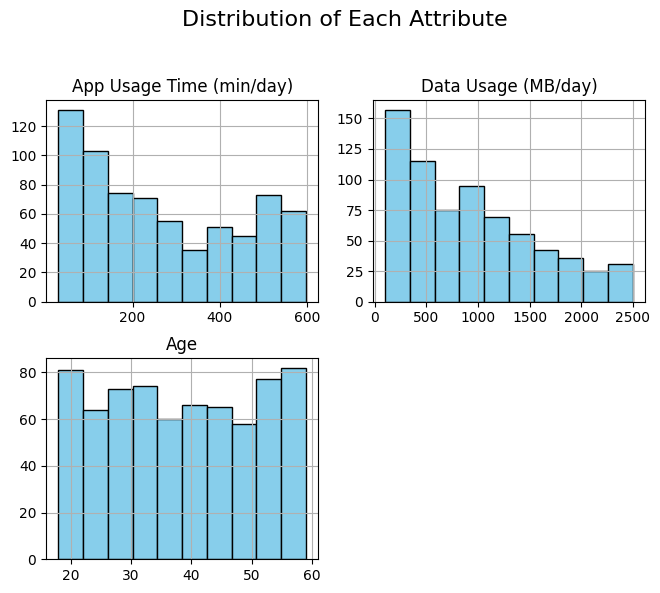

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the dataset
df = pd.read_csv("https://raw.githubusercontent.com/ds4ph-bme/capstone-project-pratibhapradeep/refs/heads/main/user_behavior_dataset.csv")
# Basic preprocessing
df = df.drop(columns=["User ID", "Device Model", "Operating System", "Gender"])
X = df.drop("User Behavior Class", axis=1)
y = df["User Behavior Class"]
X = X.drop(columns=['Battery Drain (mAh/day)', 'Number of Apps Installed', 'Screen On Time (hours/day)'])

# Plot histograms for each attribute
X.hist(figsize=(7, 6), bins=10, color='skyblue', edgecolor='black')
plt.suptitle("Distribution of Each Attribute", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.95, 0.95])  # Adjust rect as needed to tighten the layout
plt.subplots_adjust(hspace=0.28, wspace=0.2)  # Increase spacing between plots
plt.show()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert data to tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values - 1, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values - 1, dtype=torch.long)

CNN Accuracy: 99.29%


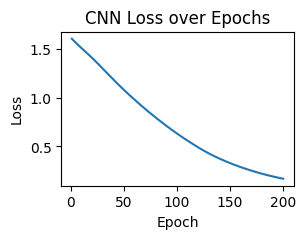

In [ ]:
# Define the CNN model
class CNN(nn.Module):
    def __init__(self, input_size):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(64 * (input_size - 2), 32) # Adjust the dimensions according to input
        self.fc2 = nn.Linear(32, len(y.unique())) # Number of classes

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return x

input_size = X_train_tensor.shape[1]
model = CNN(input_size)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 200
loss_values = []
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor.unsqueeze(1))  # CNN expects 1D input for time series/structured data
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    loss_values.append(loss.item())

# Evaluate the CNN
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor.unsqueeze(1))
    _, predicted = torch.max(outputs, 1)
    accuracy = accuracy_score(predicted, y_test_tensor)
    print(f'CNN Accuracy: {accuracy * 100:.2f}%')

# Plotting CNN Loss
plt.figure(figsize=(3, 2))
plt.plot(np.arange(1, num_epochs + 1), loss_values)
plt.title('CNN Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
# CNN Confusion Matrix and Classification Report
cnn_cm = confusion_matrix(y_test_tensor, predicted)
cnn_cr = classification_report(y_test_tensor, predicted)
print(f"CNN Confusion Matrix:\n", cnn_cm)
print(f"CNN Classification Report:\n", cnn_cr)

CNN Confusion Matrix:
 [[26  1  0  0  0]
 [ 0 29  0  0  0]
 [ 0  0 29  0  0]
 [ 0  0  0 28  0]
 [ 0  0  0  0 27]]
CNN Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98        27
           1       0.97      1.00      0.98        29
           2       1.00      1.00      1.00        29
           3       1.00      1.00      1.00        28
           4       1.00      1.00      1.00        27

    accuracy                           0.99       140
   macro avg       0.99      0.99      0.99       140
weighted avg       0.99      0.99      0.99       140



In [ ]:
# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=10, max_depth=10, random_state=42)
rf.fit(X_train_scaled, y_train)
rf_pred = rf.predict(X_test_scaled)

# Evaluate Random Forest
rf_accuracy = accuracy_score(rf_pred, y_test)
print(f'Random Forest Accuracy: {rf_accuracy * 100:.2f}%')

# Using cross-validation for Random Forest to avoid overfitting
cv_scores = cross_val_score(rf, X_train_scaled, y_train, cv=10)  # 5-fold cross-validation
print(f'Random Forest Cross-Validation Accuracy: {np.mean(cv_scores) * 100:.2f}%')

# Random Forest Confusion Matrix and Classification Report
rf_cm = confusion_matrix(y_test, rf_pred)
rf_cr = classification_report(y_test, rf_pred)
print(f"Random Forest Confusion Matrix:\n", rf_cm)
print(f"Random Forest Classification Report:\n", rf_cr)

Random Forest Accuracy: 100.00%
Random Forest Cross-Validation Accuracy: 99.82%
Random Forest Confusion Matrix:
 [[27  0  0  0  0]
 [ 0 29  0  0  0]
 [ 0  0 29  0  0]
 [ 0  0  0 28  0]
 [ 0  0  0  0 27]]
Random Forest Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        27
           2       1.00      1.00      1.00        29
           3       1.00      1.00      1.00        29
           4       1.00      1.00      1.00        28
           5       1.00      1.00      1.00        27

    accuracy                           1.00       140
   macro avg       1.00      1.00      1.00       140
weighted avg       1.00      1.00      1.00       140



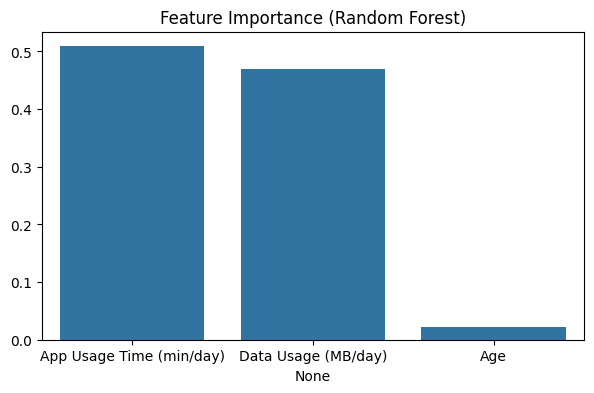

In [ ]:
importances = rf.feature_importances_  # Extract feature importances from the Random Forest model
indices = np.argsort(importances)[::-1]  # Sort feature importances in descending order
# Plot the feature importances
plt.figure(figsize=(7, 4))
sns.barplot(x=X.columns[indices], y=importances[indices])
plt.title('Feature Importance (Random Forest)')
plt.xticks(rotation=0)
plt.show()

Logistic Regression Accuracy: 76.43%
Logistic Regression Cross-Validation Accuracy: 73.39%
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           1       0.59      1.00      0.74        27
           2       0.59      0.34      0.43        29
           3       0.91      0.72      0.81        29
           4       0.96      0.79      0.86        28
           5       0.87      1.00      0.93        27

    accuracy                           0.76       140
   macro avg       0.78      0.77      0.76       140
weighted avg       0.78      0.76      0.75       140

Logistic Regression Confusion Matrix:
 [[27  0  0  0  0]
 [19 10  0  0  0]
 [ 0  7 21  1  0]
 [ 0  0  2 22  4]
 [ 0  0  0  0 27]]


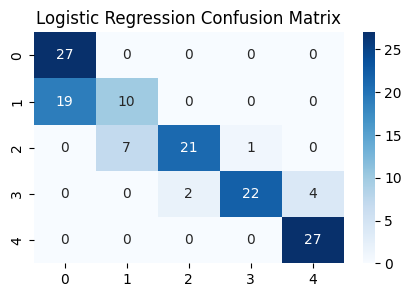

In [ ]:
# Create and train the Logistic Regression model
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg = LogisticRegression(penalty='l2', C=0.01)  # You can tune C parameter to control regularization strength
log_reg.fit(X_train_scaled, y_train)

# Make predictions
log_reg_pred = log_reg.predict(X_test_scaled)
# Evaluate the model
log_reg_accuracy = accuracy_score(y_test, log_reg_pred)
print(f'Logistic Regression Accuracy: {log_reg_accuracy * 100:.2f}%')

# Perform cross-validation
cv_scores = cross_val_score(log_reg, X_train_scaled, y_train, cv=5)
print(f'Logistic Regression Cross-Validation Accuracy: {np.mean(cv_scores) * 100:.2f}%')

# Print classification report and confusion matrix
log_reg_cr = classification_report(y_test, log_reg_pred)
print(f"Logistic Regression Classification Report:\n", log_reg_cr)
log_reg_cm = confusion_matrix(y_test, log_reg_pred)
print(f"Logistic Regression Confusion Matrix:\n", log_reg_cm)

# Plot confusion matrix heatmap
plt.figure(figsize=(5, 3))
sns.heatmap(log_reg_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

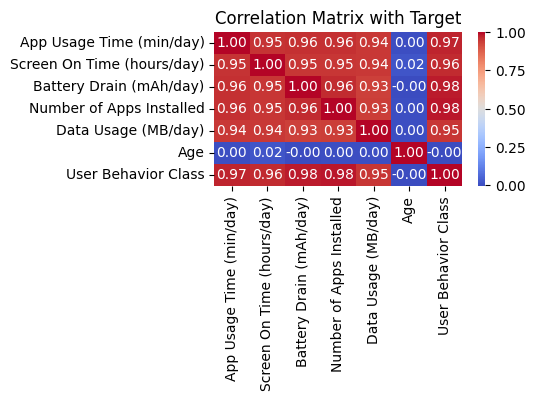

In [ ]:
# Check correlation of all features with the target variable 'User Behavior Class'
df_with_target = df.copy()
df_with_target['User Behavior Class'] = y
corr_matrix = df_with_target.corr()

# Plot heatmap to visualize correlations
plt.figure(figsize=(4, 2))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix with Target')
plt.show()

**Limitations and Future Improvements**
One limitation is overfitting, particularly in the Random Forest model, which achieved perfect accuracy. While cross-validation was used to mitigate overfitting, the imbalanced nature of the dataset may still impact the generalization of the model. Another limitation is that the choice of features, such as mobile usage time, battery drain, and data usage, might not capture all relevant behaviors. Future analyses could explore more advanced techniques to address class imbalance, such as SMOTE. Additionally, other deep learning architectures such as LSTMs, could be tested, particularly if time-series data is included in future datasets. Another future exploration could involve incorporating external datasets to improve prediction accuracy.

Khorasani, V. (2023). Mobile Device Usage and User Behavior Dataset [Data set]. Kaggle. https://www.kaggle.com/datasets/valakhorasani/mobile-device-usage-and-user-behavior-dataset?resource=download

